<a href="https://colab.research.google.com/github/ndronen/econdata/blob/main/notebooks/When_will_the_pandemic_surplus_savings_run_out%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Shortly after the COVID-19 pandemic struck in early 2020, governments around the world injected trillions of dollars of fiscal support into their economies, leading to a surplus in savings. Since then, central banks have raised rates to constrain the inflation that occurred when economies re-opened and consumers started spending more freely. The size of the remaining savings that accrued during the pandemic is an interesting question and can speak to how strong consumption can be for how much longer. 

If my analysis is correct, it has implications for central bank tightening, labor markets, and financial conditions in 2023 and 2024. Take my analysis with a grain of salt, as I am not a trained economist. I only do this as a hobby.

I use the [Net private saving (W202RC1Q027SBEA)](https://fred.stlouisfed.org/series/W202RC1Q027SBEA#0) series from FRED. I estimate the total excess net private savings during the pandemic as the sum of net private savings above the historical mean (with that mean computed from 2014 until today, plus a fudge factor to make plotting nice). Since the end of the pandemic, there has been a notable deficit in net private savings below this historical mean. We assume that the consumer is gradually depleting the excess savings accrued during the pandemic and that net private savings will revert to that historical mean once consumers have depleted the excess savings.

To estimate how long it will take to deplete these excess savings, I naively amortize the remaining surplus at the same rate as the most recent data in the series (2022-10-01), and arrive at an estimated 8.6 months remaining. Projecting this out from the end of the series, under my assumptions, the US consumer will continue to spend lavishly well into 2024.

In [1]:
#@title Imports
import os
import re
from textwrap import wrap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#@title Load data
NET_PRIVATE_SAVINGS_URL = os.path.join(
    "https://raw.githubusercontent.com/ndronen/econdata",
    "d4a66ce1a07fd4c32207491da7ec085ca2d4bd77",
    "data",
    "net-private-savings-1995-2022.csv"
)
df = pd.read_csv(NET_PRIVATE_SAVINGS_URL)

In [3]:
#@title Preprocess data

# Focus on years after GFC.
df_recent = df[df.DATE > '2014-01-01']

# Conservatively estimate net private savings over this period.
mean_net_private_savings = 1.05 * df_recent.W202RC1Q027SBEA.mean()

# Separate pandemic and post-pandemic periods.
df_pandemic = df[(df.DATE >= '2020-01-01') & (df.DATE <= '2021-10-01')]
df_post_pandemic = df[df.DATE >= df_pandemic.DATE.values[-1]]

# Compute absolute differeces from mean over these periods (L1 norm).
pandemic_deviance = (df_pandemic.W202RC1Q027SBEA - mean_net_private_savings).abs()
post_pandemic_deviance = (df_post_pandemic.W202RC1Q027SBEA - mean_net_private_savings).abs()

surplus = pandemic_deviance.sum()
deficit = post_pandemic_deviance.sum()

# Assume that net private savings is computed by period and so differences accumulate.
remaining_surplus = surplus - deficit

# Assume no trend from most recent measurement, so deficit is horizontal from most recent deficit.
post_pandemic_trend = post_pandemic_deviance.values[-1]

# How many quarters remain until we exhaust the remaining surplus?
remaining_quarters = remaining_surplus / post_pandemic_trend
print(f"The remaining surplus savings will last approximately {remaining_quarters:0.1f} more quarters from the end of the series.")

The remaining surplus savings will last approximately 8.6 more quarters from the end of the series.


In [4]:
#@title Project below-mean deficit spending out for as long as pandemic surplus remains.

projected_data = [
    ("2022-10-01", mean_net_private_savings - post_pandemic_trend),
    ("2023-01-01", mean_net_private_savings - post_pandemic_trend),
    ("2023-04-01", mean_net_private_savings - post_pandemic_trend),
    ("2023-07-01", mean_net_private_savings - post_pandemic_trend),
    ("2023-10-01", mean_net_private_savings - post_pandemic_trend),
    ("2024-01-01", mean_net_private_savings - post_pandemic_trend),
    ("2024-04-01", mean_net_private_savings - post_pandemic_trend),
    ("2024-07-01", mean_net_private_savings - post_pandemic_trend),
    # Last quarter of deficit spending is what little remains after 8 quarters.
    ("2024-10-01", mean_net_private_savings - (remaining_surplus % post_pandemic_trend)),
    # After that, we mean revert.
    ("2025-11-01", mean_net_private_savings)
]
df_projected = pd.DataFrame(data=projected_data, columns=df.columns)
df_new = pd.concat((df_recent, df_projected))

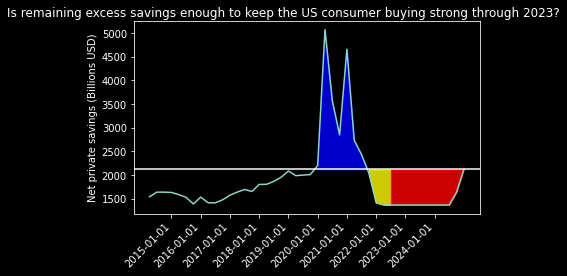

In [5]:
#@title Plot the surplus, deficit, and sustainable projected deficit.

plt.style.use('dark_background')

# Plot quarterly savings since GFC.

def plot_pandemic_savings(df, mean_net_private_savings):
    fig, ax = plt.subplots(1)
    ax.plot(df.DATE, df.W202RC1Q027SBEA)
    ax.axhline(mean_net_private_savings)
    ax.set_ylabel("Net private savings (Billions USD)")
    return fig, ax

fig, ax = plot_pandemic_savings(df_new, mean_net_private_savings)

alpha = 0.8

# Fill the savings surplus that occurred during the pandemic.
ax.fill_between(
    x=df_pandemic.DATE,
    y1=df_pandemic.W202RC1Q027SBEA, 
    y2=mean_net_private_savings,
    color="blue",
    alpha=alpha,
    interpolate=True
)

# Fill the savings deficit that occurred after the pandemic.
ax.fill_between(
    x=df_post_pandemic.DATE,
    y1=mean_net_private_savings,
    y2=df_post_pandemic.W202RC1Q027SBEA,
    color="yellow",
    alpha=alpha
)

# Prepend the previous row to eliminate gaps in the filled area.
df_projected_fill = pd.concat(
    (df_post_pandemic.tail(1), df_projected)
)
# Fill the projected deficit spending until the surplus is exhausted.
ax.fill_between(
    x=df_projected_fill.DATE,
    y1=mean_net_private_savings,
    y2=df_projected_fill.W202RC1Q027SBEA,
    color="red",
    alpha=alpha
)

xticks = []
xtick_labels = []
for i, date in enumerate(df_new.DATE):
    if date.endswith("01-01"):
        xticks.append(i)
        xtick_labels.append(date)
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)

fig.suptitle(f"Is remaining excess savings enough to keep the US consumer buying strong through 2023?")
fig.autofmt_xdate(rotation=45)
fig.tight_layout(pad=2)